In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


## Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [21]:
# напишите запрос
query = '''
SELECT (DATE_TRUNC ('month', creation_date):: date) AS month_date,
      SUM (views_count) AS total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('year', creation_date) = '2008-01-01' AND views_count !=0
GROUP BY month_date
ORDER BY total_views DESC; 
'''

# выполните запрос
sample_df1 = pd.read_sql_query(query, con=engine)
sample_df1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


*напишите ваш ответ здесь*


Наибольшее количество просмотров постов сложилось за сентябрь 2008 года, что скорее всего связано с началом учебного года. Далее количество просмотров постепенно уменьшалось. Отсутствие данных до июля 2008 года - возможно сервис только открылся в июле 2008 года? Так как хотя бы единичные просмотры все равно были бы выявлены при анализе. А их нет совсем.


## Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
# напишите запрос
query = '''
SELECT u.display_name AS name,
       COUNT (DISTINCT p.user_id) AS counts
       
FROM stackoverflow.users AS u
JOIN stackoverflow.posts AS p ON u.id=p.user_id
JOIN stackoverflow.post_types AS p_t ON p.post_type_id=p_t.id

WHERE p_t.type = 'Answer' 
AND p.creation_date >= u.creation_date AND p.creation_date <= (u.creation_date+INTERVAL '1 month')

GROUP BY name
HAVING  COUNT(*) > 100;
'''

# выполните запрос
active_users = pd.read_sql_query(query, con=engine)
active_users

,name,counts
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


<details>

<summary>Подсказка</summary>
Вам нужно присоединить несколько таблиц — изучите внимательнее описание базы. Чтобы добавить промежуток времени к дате, используйте ключевое слово INTERVAL, например, так: <дата> + INTERVAL '1 year 2 months 3 days'
.</details>

Какие аномалии наблюдаются в данных? О чём они говорят?

In [8]:
# напишите ваш ответ здесь
active_users['counts'].value_counts()

1     57
16     3
3      2
10     2
15     2
29     2
5      1
7      1
8      1
9      1
11     1
12     1
19     1
21     1
Name: counts, dtype: int64

## Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [9]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', p.creation_date)::date AS month, 
 COUNT(*) 
FROM stackoverflow.posts p 
WHERE user_id IN (SELECT u.id AS user_id 
 FROM stackoverflow.users u  
 JOIN stackoverflow.posts p ON u.id=p.user_id 
 WHERE DATE_TRUNC('month', u.creation_date) = '2008-09-01' 
 AND DATE_TRUNC('month', p.creation_date) = '2008-12-01') 
GROUP BY 1 
ORDER BY month DESC;
       
'''

# выполните запрос
posts_2008 = pd.read_sql_query(query, con=engine)
posts_2008

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые зарегистрировались в сентябре 2008 года и оставили хотя бы один пост в декабре. Затем используйте результат для среза и посчитайте посты по месяцам.</details>

Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

*напишите ваш ответ здесь*
Аномалия, что пользователи зарегистрировались в сентябре 2008 года, а посты выложены в августе 2008 года. Причем по сравнению с другими месяцами очень большой разрыв в количестве постов. Возможно процесс регистрации пользователей затянулся и на самом деле они зарегистрировались в августе, но долгая проверка, или возможно подтверждение данных прошло в сентябре

## Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [10]:
# напишите запрос
query = '''
SELECT user_id,
creation_date,
views_count,
SUM (views_count) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts p
ORDER BY 1,2;
'''

# выполните запрос
posts_sorts = pd.read_sql_query(query, con=engine)
posts_sorts

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


## Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [11]:
# напишите запрос
query = '''
WITH post AS 
(SELECT user_id, 
        DATE_TRUNC('day', creation_date)::date AS day, 
        COUNT(id) AS count 
FROM stackoverflow.posts 
WHERE creation_date >= '2008-08-01' AND creation_date < '2008-09-01' AND user_id IN 
                                         (SELECT user_id 
                                          FROM stackoverflow.posts 
                                          WHERE creation_date >= '2008-08-01' AND creation_date < '2008-09-01' 
                                          GROUP BY user_id                                           
                                          HAVING COUNT(user_id) > 120) 
GROUP BY user_id, day 
HAVING COUNT(id) > 0) 
SELECT user_id, 
       AVG(count) AS avg_daily 
FROM post
GROUP BY user_id
ORDER BY avg_daily;
'''

# выполните запрос
posts_120 = pd.read_sql_query(query, con=engine)
posts_120

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


## Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [12]:
# напишите запрос
query = '''
SELECT ROUND(AVG(days_count),0) AS result
FROM (SELECT user_id,
          COUNT(DISTINCT day) AS days_count
   FROM (SELECT user_id,
          DATE_TRUNC('day', creation_date) AS day
   FROM stackoverflow.posts
   WHERE creation_date >= '2008-12-01'
     AND creation_date <= '2008-12-08'
   GROUP BY user_id,
            day
   ORDER BY user_id,
            day) AS temp_table
   GROUP BY user_id
   ORDER BY user_id) AS u_max;


'''

# выполните запрос
count_active_days = pd.read_sql_query(query, con=engine)
count_active_days

,result
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

*напишите ваш ответ здесь*
Здесь наверное вопрос не про таблицу, а про значение 2 - всего два дня из семи - среднее количество активных дней пользователя. Хотя, если принимать во внимание, что у некоторых пользователей в день было множество постов, думаю эта цифра не очень показательна. Нужно больше данных для анализа.

## Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [13]:
# напишите запрос
query = '''
WITH abc AS
(SELECT user_id,
       creation_date,
       LAG (DATE_TRUNC ('month', creation_date),2,NULL) OVER (PARTITION BY user_id ORDER BY (DATE_TRUNC ('month', creation_date))) AS second_last_month
FROM stackoverflow.posts)
SELECT user_id,
       creation_date,
       CASE
           WHEN second_last_month ='2008-01-01' THEN 'January'
          WHEN second_last_month ='2008-02-01' THEN 'February'
          WHEN second_last_month ='2008-03-01' THEN 'March'
          WHEN second_last_month ='2008-04-01' THEN 'April'
          WHEN second_last_month ='2008-05-01' THEN 'May'
          WHEN second_last_month ='2008-06-01' THEN 'June'
          WHEN second_last_month ='2008-07-01' THEN 'July'
          WHEN second_last_month ='2008-08-01' THEN 'August'
          WHEN second_last_month ='2008-09-01' THEN 'September'
          WHEN second_last_month ='2008-10-01' THEN 'October'
          WHEN second_last_month ='2008-11-01' THEN 'November'
          WHEN second_last_month ='2008-12-01' THEN 'December'
       END
FROM abc;
'''

# выполните запрос
second_last_month = pd.read_sql_query(query, con=engine)
second_last_month

,user_id,creation_date,case
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:56:41,None
2,1,2008-07-31 23:55:38,July
3,1,2008-08-12 05:02:49,July
4,1,2008-08-25 00:11:44,July
...,...,...,...
243791,5696608,2008-12-30 16:32:12,December
243792,5696608,2008-12-22 19:58:23,December
243793,5696608,2008-12-22 18:09:31,December
243794,5696608,2008-12-23 16:00:37,December


## Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [14]:
# напишите запрос
query = '''
WITH profile AS  
 (SELECT DISTINCT 
 user_id, 
 DATE_TRUNC('month', MIN(creation_date)) AS cohort_dt, 
 COUNT(*) OVER (PARTITION BY DATE_TRUNC('month', MIN(creation_date))) AS cohort_users_cnt 
 FROM stackoverflow.posts 
 GROUP BY user_id), 
 sessions AS 
 (SELECT user_id, 
 DATE_TRUNC('month', creation_date) AS session_date 
 FROM stackoverflow.posts 
 GROUP BY 1, 
                2)
SELECT p.cohort_dt, 
 s.session_date, 
 COUNT(s.user_id) AS users_cnt, 
 p.cohort_users_cnt, 
 ROUND(COUNT(s.user_id) * 100.0 / p.cohort_users_cnt, 2) AS retention_rate 
FROM profile AS p 
JOIN sessions AS s ON p.user_id = s.user_id 
GROUP BY 1, 
         2,
         4
'''

# выполните запрос
retention_rate_df = pd.read_sql_query(query, con=engine)
retention_rate_df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


In [15]:
#CODE REVIEW
profile_cohort = """
with user_cohort as (-- профиль 
					SELECT user_id AS user_id,
					DATE_TRUNC('month', creation_date) as post_month,
					min(DATE_TRUNC('month', creation_date)) OVER(PARTITION BY user_id) AS first_month_post
					FROM stackoverflow.posts),
cohort_sizes as (-- размеры когорт
				select first_month_post,
					count(distinct user_id) as size
				from user_cohort
				group by first_month_post)
SELECT *
FROM user_cohort p
JOIN cohort_sizes c
ON p.first_month_post = c.first_month_post;
"""

pd.read_sql(profile_cohort, con=engine).head(10)

,user_id,post_month,first_month_post,first_month_post,size
0,1,2008-08-01,2008-07-01,2008-07-01,3
1,1,2008-07-01,2008-07-01,2008-07-01,3
2,1,2008-08-01,2008-07-01,2008-07-01,3
3,1,2008-09-01,2008-07-01,2008-07-01,3
4,1,2008-08-01,2008-07-01,2008-07-01,3
5,1,2008-07-01,2008-07-01,2008-07-01,3
6,1,2008-09-01,2008-07-01,2008-07-01,3
7,1,2008-08-01,2008-07-01,2008-07-01,3
8,1,2008-08-01,2008-07-01,2008-07-01,3
9,1,2008-09-01,2008-07-01,2008-07-01,3


Далее справиться необходимо тебе. В полученных данных <code>size</code> - размер когорты - это означает, что полученное тобой user_cnt не должен быть больше его

Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

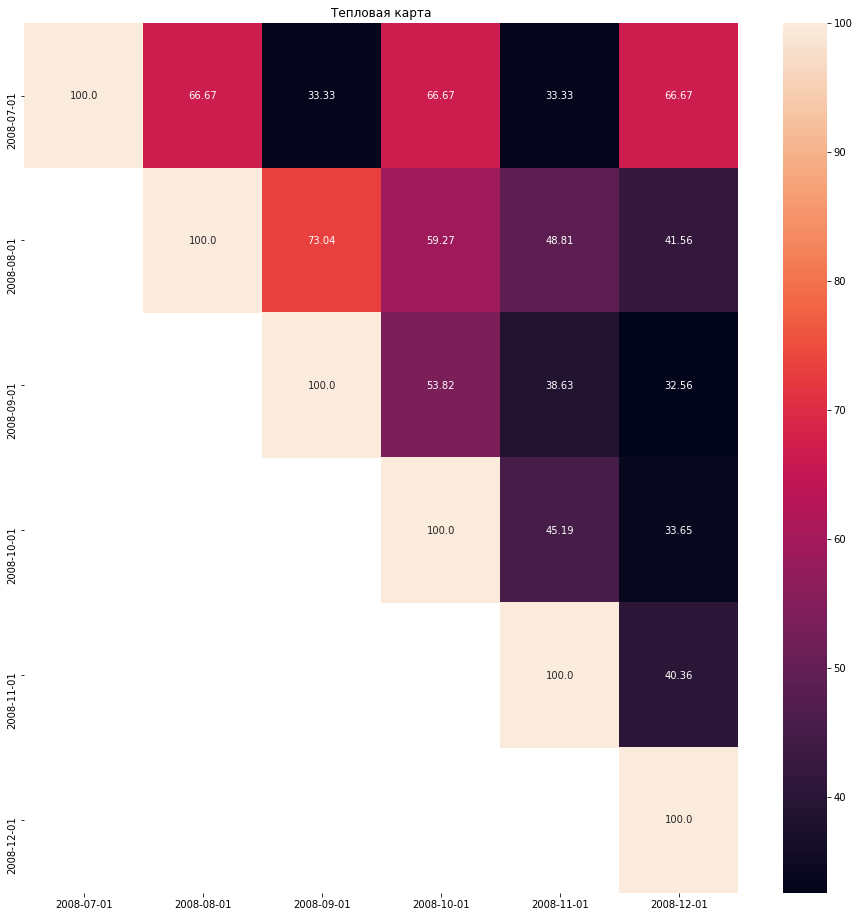

In [16]:
# постройте тепловую карту Retention Rate
# создаём сводную таблицу с результатами
retention = retention_rate_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

*опишите аномалии или другие необычные явления и сформулируйте гипотезы*
Меньше всего их было в когорте июля 2008 года. Зато во втором месяце пользователи активизировались. Самая активная когорта - зарегистрировавшаяся в декабре 2008 года. Также видим много аномалий, когда пользователи зарегистрировались позже, чем дата выхода их первого поста. Они отмечены черным цветом на тепловой карте.

## Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [17]:
# напишите запрос
query = '''
WITH qwerty AS
(SELECT DISTINCT EXTRACT (MONTH FROM CAST(creation_date AS timestamp)) AS creation_month,
       COUNT (id) OVER (PARTITION BY EXTRACT (MONTH FROM CAST(creation_date AS timestamp))) AS posts_count
FROM stackoverflow.posts
WHERE creation_date >= '2008-09-01' AND creation_date < '2009-01-01'
GROUP BY creation_date, id)
SELECT creation_month,
       posts_count,
       ROUND((((posts_count::numeric / LAG(posts_count, 1, NULL) OVER (ORDER BY creation_month)) - 1) * 100),2) AS percentage
FROM qwerty;
'''
 

# выполните запрос
creation_month = pd.read_sql_query(query, con=engine)
creation_month

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

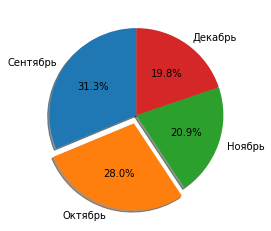

In [18]:
# постройте круговую диаграмму с количеством постов по месяцам

labels = 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'
sizes = [70371,63102,46975,44592]
# строим диаграмму
fig1, ax1 = plt.subplots()
explode = (0, 0.1, 0, 0) 
ax1.pie(sizes, explode=explode, labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

## Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [19]:
# напишите запрос
query = '''
SELECT DISTINCT EXTRACT (WEEK FROM CAST(creation_date AS date)) AS week_creation,
       MAX(creation_date) OVER (ORDER BY EXTRACT (WEEK FROM CAST(creation_date AS date)))
FROM stackoverflow.posts 
WHERE creation_date >= '2008-10-01' AND creation_date < '2008-11-01'
AND user_id in (SELECT user_id
                 FROM stackoverflow.posts 
                 GROUP BY user_id
                 ORDER BY COUNT (id) DESC
                 LIMIT 1)
GROUP BY week_creation, creation_date;
'''


# выполните запрос
max_post = pd.read_sql_query(query, con=engine)
max_post

,week_creation,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
